In [7]:
# Author: Benedikt Lins
# Modified by: Niels Danger

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os


NUM_PUBLISHERS = int(8)
SIMULATION_TIME = int(30) #minutes
NUM_CAMPAIGNS =  int(20)
ADS_PER_CAMPAIGN =  int(200)
NUM_PAGES = int(50)
NUM_USERS = int(100)
START_EVENT_RATE = int(100) # events per second
TRACES_SAVE_PATH = os.getcwd()
AD_TYPES = ["banner", "modal", "sponsored-search", "mail", "mobile"]
EVENT_TYPES = [0,1,2]#["view", "click", "purchase"]

def make_ids(num=100):
    out = []
    for _ in range(num):
        #out.append(str(uuid.uuid4()))
        out.append(_)
    return out


def make_event(time, u_ids, p_ids, a_ids):
    out = []
    out.append(time)
    out.append(np.random.choice(u_ids))
    out.append(np.random.choice(p_ids))
    out.append(np.random.choice(a_ids))
    out.append(np.random.choice(AD_TYPES))
    out.append(np.random.choice(EVENT_TYPES))
    return out

def rnd_campaign(adToCampaign, campaignIds):
    selection_list = []
    addsPerCampaign = {}
    for i in campaignIds:
        addsPerCampaign[i] = 0
    for ad in adToCampaign:
        addsPerCampaign[adToCampaign[ad]] += 1
    for camp in addsPerCampaign:
        if addsPerCampaign[camp] < ADS_PER_CAMPAIGN:
            selection_list.append(camp)
    return np.random.choice(selection_list)

def get_random_interval(start, totalEnd, steps):
    end = np.random.uniform(low=0.1, high=0.25)*totalEnd+start
    return np.arange(start, end, steps)

def createEventTraceNew(numPublishers=8):
    time = 0 #sec
    endTime = SIMULATION_TIME * 60 #sec
    campaign_ids = make_ids(NUM_CAMPAIGNS)
    adToCampaign = {}
    adToCampaignOut = []
    ad_ids = make_ids(NUM_CAMPAIGNS*ADS_PER_CAMPAIGN)
    for ad in ad_ids:
        camp = rnd_campaign(adToCampaign, campaign_ids)
        adToCampaignOut.append([ad, camp])
        adToCampaign[ad] = camp
    user_ids = make_ids(NUM_USERS)
    page_ids = make_ids(NUM_PAGES)
    start_interval = 1.0 / START_EVENT_RATE
    interval_s = start_interval
    times = np.arange(start=0, stop=endTime*0.1, step=interval_s)
    interval_s = 0.8 * start_interval
    times = np.concatenate((times, np.arange(start=times[-1]+interval_s, stop=endTime*0.2, step=interval_s)))
    interval_s = 0.4 * start_interval
    times = np.concatenate((times, np.arange(start=times[-1]+interval_s, stop=endTime*0.3, step=interval_s)))
    interval_s = 0.2 * start_interval
    times = np.concatenate((times, np.arange(start=times[-1]+interval_s, stop=endTime*0.4, step=interval_s)))
    interval_s = 0.5 * start_interval
    times = np.concatenate((times, np.arange(start=times[-1]+interval_s, stop=endTime*0.5, step=interval_s)))
    interval_s = 0.3 * start_interval
    times = np.concatenate((times, np.arange(start=times[-1]+interval_s, stop=endTime*0.6, step=interval_s)))
    interval_s = 0.2 * start_interval
    times = np.concatenate((times, np.arange(start=times[-1]+interval_s, stop=endTime*0.8, step=interval_s)))
    interval_s = 0.5 * start_interval
    times = np.concatenate((times, np.arange(start=times[-1]+interval_s, stop=endTime, step=interval_s)))
    times = np.round(times, 8)
    print("times are: (count: ", len(times), ")\n", times)

    traces = {} # contains lists tuples (time, user-id, page-id, ad-id, ad-type, event-type)
    for t in times:
        for pub in range(numPublishers):
            if pub not in traces:
                traces[pub] = []
            traces[pub].append(make_event(t, user_ids, page_ids, ad_ids))
        if t % 10000 == 0:
            print("10000 more traces lines generated at {}",dt.datetime.now())
    for key in traces:
        tmp = pd.DataFrame(traces[key], columns=["Time","UID","PID","AID","AType","EType"])
        next_event = []
        rows = tmp.values
        for i in range(rows.shape[0]-1):
            current_time = rows[i,:].ravel()[0]
            next_time = rows[i+1,:].ravel()[0]
            diff = next_time - current_time
            next_event.append(diff)
        next_event.append(0)
        tmp["Next"] = next_event
        traces[key] = tmp
    return traces, adToCampaignOut

def write_traces(traces, campDict):
    for key in traces:
        i = key+1
        traces[key].to_csv("%s/yahooTraceP%s.csv" % (TRACES_SAVE_PATH, i), sep=",", index=False)
    df = pd.DataFrame(campDict, columns=["AID","CID"])
    df.to_csv("%s/yahooJoins.csv" % (TRACES_SAVE_PATH), sep=",", index=False)


In [8]:
traces, joinDict = createEventTraceNew(numPublishers=NUM_PUBLISHERS)
write_traces(traces, joinDict)

sec1 start:  179.99 sec1 end:  360.0
sec1 start:  359.99800000022003 sec1 end:  720.0
times are: (count:  523502 )
 [0.000000e+00 1.000000e-02 2.000000e-02 ... 1.799990e+03 1.799995e+03
 1.800000e+03]
[1.75 1.76 1.77 1.78 1.79 1.8  1.81 1.82 1.83 1.84 1.85 1.86 1.87 1.88
 1.89]


In [9]:
traces[0].head()

,Time,UID,PID,AID,AType,EType,Next
0,0.00,75,43,1214,mail,0,0.01
1,0.01,22,23,794,modal,1,0.01
2,0.02,49,9,414,banner,0,0.01
3,0.03,64,43,2663,modal,1,0.01
4,0.04,56,39,3542,modal,1,0.01


Text(0, 0.5, '#EventsPerSecond')

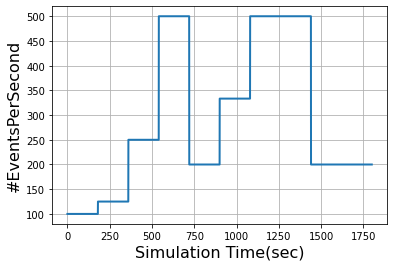

In [17]:
plt.plot(traces[0].Time, 1/traces[0].Next, linewidth=2)
plt.grid()
plt.xlabel("Simulation Time(sec)", fontsize=16)
plt.ylabel("#EventsPerSecond", fontsize=16)
plt.savefig(str(os.getcwd()) + "/YahooEventRates.pdf", dpi=500)


